In [45]:
import pandas as pd
import glob

merge all the csv files into one data frame

In [46]:
import zipfile
import os

path = "/content/data/api_data_aadhar_demographic.zip"

# Define the extraction directory
extraction_path = "/content/uidai_data/extracted"

# Create the extraction directory if it doesn't exist
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# Extract the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# List all csv files in the extracted directory, searching recursively
all_files = glob.glob(extraction_path + "/**/*.csv", recursive=True)

# Check if any files were found
if not all_files:
    print(f"No CSV files found in the extracted directory: {extraction_path}")
else:
    # Read and merge
    df_list = []
    for file in all_files:
        temp_df = pd.read_csv(file)
        df_list.append(temp_df)

    master_df = pd.concat(df_list, ignore_index=True)
    print(f"Successfully merged {len(all_files)} CSV files into master_df.")
    print(f"Master DataFrame shape: {master_df.shape}")

Successfully merged 5 CSV files into master_df.
Master DataFrame shape: (2071700, 6)


In [47]:
master_df.head()


,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,18-11-2025,Karnataka,Hasan,573118,0,2
1,18-11-2025,Karnataka,Hasan,573124,1,3
2,18-11-2025,Karnataka,Hasan,573150,0,2
3,18-11-2025,Karnataka,Hassan,573113,0,1
4,18-11-2025,Karnataka,Hassan,573120,1,4


In [48]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071700 entries, 0 to 2071699
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   date           object
 1   state          object
 2   district       object
 3   pincode        int64 
 4   demo_age_5_17  int64 
 5   demo_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 94.8+ MB


convert date to proper datetime

In [49]:
master_df['date'] = pd.to_datetime(master_df['date'],format = '%d-%m-%y', errors = 'coerce')

In [50]:
master_df['date'].dtype

dtype('<M8[ns]')

In [51]:
numeric_col = ['demo_age_5_17', 'demo_age_17_']

for col in numeric_col:
  master_df[col] = pd.to_numeric(master_df[col], errors = 'coerce').fillna(0).astype(int)

In [52]:
# check
master_df.isnull().sum()

,0
date,2071700
state,0
district,0
pincode,0
demo_age_5_17,0
demo_age_17_,0


In [53]:
#saving
master_df.to_csv("UIDAI_master_cleaned.csv",index = False)

In [54]:
# droping the date clmn cuz no significance
master_df = master_df.drop(columns=['date'])

In [55]:
master_df.head()

,state,district,pincode,demo_age_5_17,demo_age_17_
0,Karnataka,Hasan,573118,0,2
1,Karnataka,Hasan,573124,1,3
2,Karnataka,Hasan,573150,0,2
3,Karnataka,Hassan,573113,0,1
4,Karnataka,Hassan,573120,1,4


need to find this :
age_17_ratio = age_17_enrollment / total_enrollment


for distrcit level anomalies need to  : need a distric level table

In [56]:
district_df = (
    master_df
    .groupby(["state", "district"])
    .agg(
        total_enrollment=("demo_age_5_17", "sum"),
        age_17_enrollment=("demo_age_17_", "sum")
    )
    .reset_index()
)

In [57]:
district_df.head()
district_df.shape


(1078, 4)

the ratio of needed things

In [58]:
district_df["age_17_ratio"] = (
    district_df["age_17_enrollment"] /
    district_df["total_enrollment"]
)


anomalie logic

In [59]:
district_df["age_17_ratio_zscore"] = (
    district_df["age_17_ratio"] -
    district_df["age_17_ratio"].mean()
) / district_df["age_17_ratio"].std()


In [60]:
district_df["anomaly_flag"] = (
    district_df["age_17_ratio_zscore"].abs() > 3
)
district_df


,state,district,total_enrollment,age_17_enrollment,age_17_ratio,age_17_ratio_zscore,anomaly_flag
0,100000,100000,0,2,inf,NaN,False
1,Andaman & Nicobar Islands,Andamans,7,743,106.142857,NaN,False
2,Andaman & Nicobar Islands,Nicobars,0,4,inf,NaN,False
3,Andaman & Nicobar Islands,South Andaman,6,299,49.833333,NaN,False
4,Andaman and Nicobar Islands,Nicobar,58,729,12.568966,NaN,False
...,...,...,...,...,...,...,...
1073,Westbengal,Howrah,0,8,inf,NaN,False
1074,andhra pradesh,chittoor,5,52,10.400000,NaN,False
1075,andhra pradesh,rangareddi,0,20,inf,NaN,False
1076,odisha,Gajapati,0,20,inf,NaN,False


In [61]:
district_df.shape

(1078, 7)

In [62]:
district_df["anomaly_flag"].value_counts()


,count
anomaly_flag,
False,1078


In [63]:
district_df["anomaly_flag"].sum()


np.int64(0)

In [64]:
district_df.sort_values(
    "age_17_ratio",
    ascending=False
).head(1)


,state,district,total_enrollment,age_17_enrollment,age_17_ratio,age_17_ratio_zscore,anomaly_flag
1077,west Bengal,South 24 Parganas,0,15,inf,NaN,False


In [65]:
district_df.sort_values(
    "age_17_ratio",
    ascending=True
).head(1)


,state,district,total_enrollment,age_17_enrollment,age_17_ratio,age_17_ratio_zscore,anomaly_flag
920,Uttar Pradesh,Chandauli *,1,0,0.0,NaN,False


In [66]:
district_df["age_17_ratio_zscore"].describe()


,age_17_ratio_zscore
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [67]:
district_df["age_17_ratio_zscore"].abs().max()


nan

In [68]:
district_df["total_enrollment"].describe()


,total_enrollment
count,1078.000000
mean,4511.525046
std,5799.483592
min,0.000000
25%,171.250000
50%,2464.000000
75%,6658.750000
max,39744.000000


In [69]:
(district_df["total_enrollment"] == 0).sum()


np.int64(78)

removing the columns woth 0 total enrollment which is 78

In [70]:
district_df = district_df[district_df["total_enrollment"] > 0].copy()

In [77]:
district_df.shape


(1000, 7)

In [79]:
district_df["age_17_ratio"] = (
    district_df["age_17_enrollment"] / district_df["total_enrollment"]
)


In [80]:
district_df["age_17_ratio"].isna().sum()


np.int64(0)

In [81]:
mean = district_df["age_17_ratio"].mean()
std  = district_df["age_17_ratio"].std()

district_df["age_17_ratio_zscore"] = (
    (district_df["age_17_ratio"] - mean) / std
)


In [82]:
district_df["age_17_ratio_zscore"].describe()


,age_17_ratio_zscore
count,1.000000e+03
mean,1.136868e-16
std,1.000000e+00
min,-7.539780e-01
25%,-3.894422e-01
50%,-2.388619e-01
75%,-1.625880e-02
max,1.212570e+01


In [83]:
district_df["anomaly_flag"] = (
    district_df["age_17_ratio_zscore"].abs() > 2
)


In [84]:
district_df["anomaly_flag"].sum()


np.int64(29)

In [85]:
district_df.shape

(1000, 7)

In [86]:
district_df["age_17_ratio_zscore"].describe()

,age_17_ratio_zscore
count,1.000000e+03
mean,1.136868e-16
std,1.000000e+00
min,-7.539780e-01
25%,-3.894422e-01
50%,-2.388619e-01
75%,-1.625880e-02
max,1.212570e+01


In [87]:
# most extream districs
district_df.sort_values(
    "age_17_ratio_zscore",
    ascending=False
).head(3)


,state,district,total_enrollment,age_17_enrollment,age_17_ratio,age_17_ratio_zscore,anomaly_flag
709,Pondicherry,Yanam,1,227,227.000000,12.125697,True
155,Bihar,Sheikpura,1,177,177.000000,9.288764,True
1035,West Bengal,Koch Bihar,427,70660,165.480094,8.635140,True


In [88]:
#lowest
district_df.sort_values(
    "age_17_ratio_zscore",
    ascending=True
).head(3)


,state,district,total_enrollment,age_17_enrollment,age_17_ratio,age_17_ratio_zscore,anomaly_flag
920,Uttar Pradesh,Chandauli *,1,0,0.00,-0.753978,False
575,Manipur,Kangpokpi,2,1,0.50,-0.725609,False
318,Jammu & Kashmir,Leh (ladakh),4,3,0.75,-0.711424,False


In [89]:
district_df.to_csv("uidai_district_demographic_anomalies.csv", index=False)


In [90]:
district_df["total_enrollment"]


,total_enrollment
1,7
3,6
4,58
5,112
6,434
...,...
1062,17577
1064,455
1066,3
1067,1


adding enrollment volume anomalies

In [91]:
# Z‑score for total enrollment

In [92]:
from scipy.stats import zscore

district_df["enrollment_zscore"] = zscore(
    district_df["total_enrollment"]
)


In [93]:
district_df["enrollment_zscore"].describe()


,enrollment_zscore
count,1.000000e+03
mean,2.842171e-17
std,1.000500e+00
min,-8.276854e-01
25%,-7.615546e-01
50%,-2.998309e-01
75%,3.868821e-01
max,5.937397e+00


In [94]:
#  Flag enrollment volume anomalies
# Use a |z| > 3 rule (industry‑standard):

district_df["enrollment_anomaly"] = (
    district_df["enrollment_zscore"].abs() > 3
)


In [95]:
district_df["enrollment_anomaly"].sum()


np.int64(19)

Combined Anomaly Signal

In [96]:
# Combine ratio + volume anomalies
district_df["final_anomaly_flag"] = (
    district_df["anomaly_flag"] |
    district_df["enrollment_anomaly"]
)


In [97]:
district_df["final_anomaly_flag"].sum()


np.int64(48)

In [98]:
# Rank districts by severity
district_df["anomaly_severity"] = (
    district_df["age_17_ratio_zscore"].abs() +
    district_df["enrollment_zscore"].abs()
)


In [99]:
# Top risky districts
district_df.sort_values(
    "anomaly_severity",
    ascending=False
).head(10)


,state,district,total_enrollment,age_17_enrollment,age_17_ratio,age_17_ratio_zscore,anomaly_flag,enrollment_zscore,enrollment_anomaly,final_anomaly_flag,anomaly_severity
709,Pondicherry,Yanam,1,227,227.000000,12.125697,True,-0.827685,False,True,12.953382
155,Bihar,Sheikpura,1,177,177.000000,9.288764,True,-0.827685,False,True,10.116449
566,Maharashtra,Washim *,6,989,164.833333,8.598444,True,-0.826834,False,True,9.425278
1035,West Bengal,Koch Bihar,427,70660,165.480094,8.635140,True,-0.755171,False,True,9.390311
1018,West Bengal,Darjiling,58,8213,141.603448,7.280411,True,-0.817983,False,True,8.098394
139,Bihar,Monghyr,2,280,140.000000,7.189434,True,-0.827515,False,True,8.016949
1025,West Bengal,Haora,354,39541,111.697740,5.583601,True,-0.767597,False,True,6.351199
222,Delhi,North West Delhi,39744,274245,6.900287,-0.362465,False,5.937397,True,True,6.299862
731,Punjab,Nawanshahr,27,2931,108.555556,5.405318,True,-0.823260,False,True,6.228578
390,Karnataka,Bengaluru,38541,265383,6.885732,-0.363291,False,5.732622,True,True,6.095912


 Distribution of Age‑17 Ratio (with anomalies)

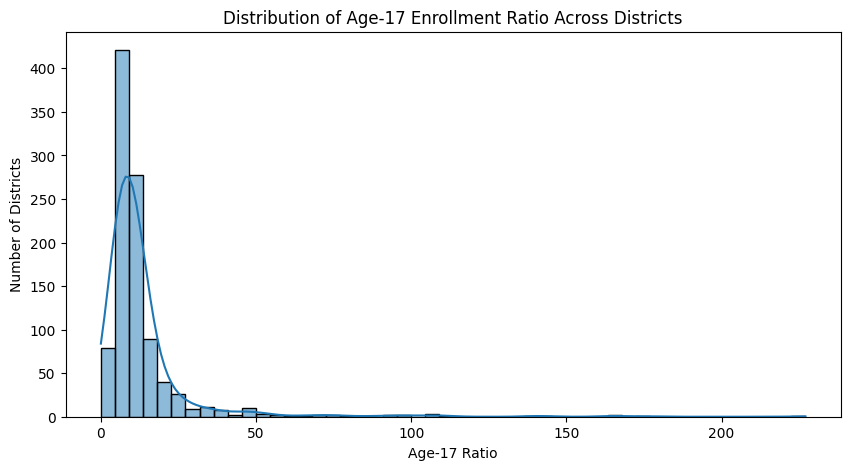

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(
    district_df["age_17_ratio"],
    bins=50,
    kde=True
)
plt.title("Distribution of Age‑17 Enrollment Ratio Across Districts")
plt.xlabel("Age‑17 Ratio")
plt.ylabel("Number of Districts")
plt.show()

# Most districts follow a normal pattern, but a small number lie at the extreme tails


Z‑score Scatter

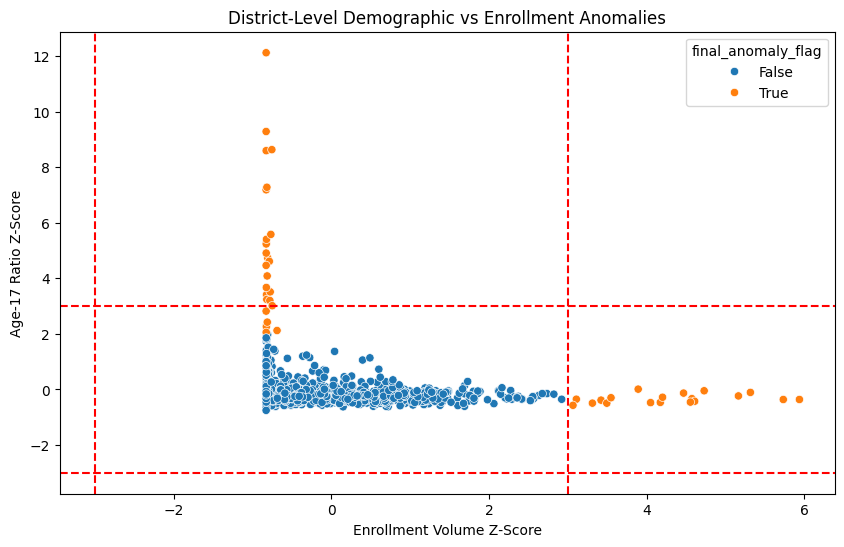

In [101]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="enrollment_zscore",
    y="age_17_ratio_zscore",
    hue="final_anomaly_flag",
    data=district_df
)

plt.axhline(3, color="red", linestyle="--")
plt.axhline(-3, color="red", linestyle="--")
plt.axvline(3, color="red", linestyle="--")
plt.axvline(-3, color="red", linestyle="--")

plt.title("District‑Level Demographic vs Enrollment Anomalies")
plt.xlabel("Enrollment Volume Z‑Score")
plt.ylabel("Age‑17 Ratio Z‑Score")
plt.show()

# Districts in the corners show simultaneous demographic and volume anomalies and are high‑priority for audit


Top 10 Anomalous Districts

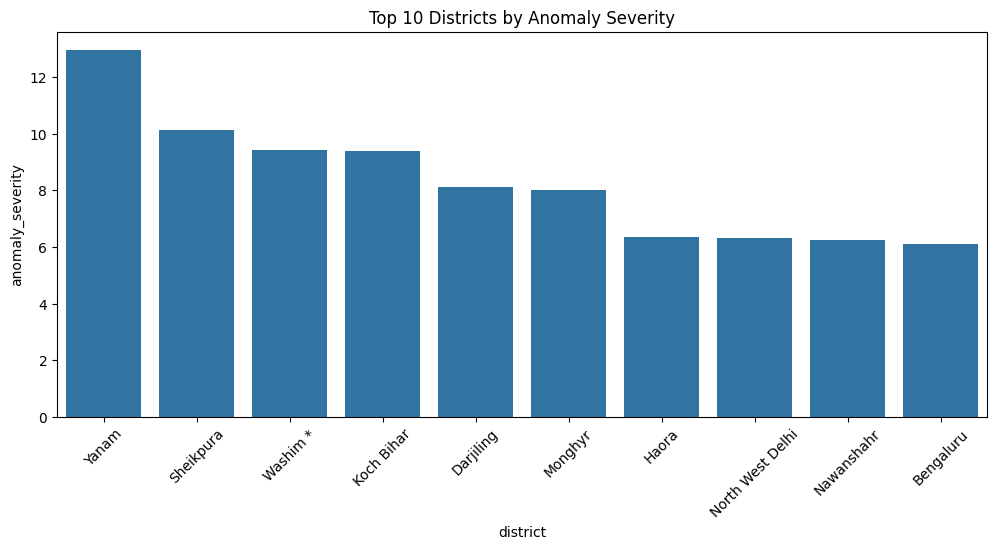

In [102]:
top10 = district_df.sort_values(
    "anomaly_severity",
    ascending=False
).head(10)

plt.figure(figsize=(12,5))
sns.barplot(
    x="district",
    y="anomaly_severity",
    data=top10
)
plt.xticks(rotation=45)
plt.title("Top 10 Districts by Anomaly Severity")
plt.show()


State‑Level Aggregation

In [103]:
# state level table
state_df = district_df.groupby("state").agg(
    num_districts=("district", "count"),

    avg_age_17_ratio=("age_17_ratio", "mean"),
    std_age_17_ratio=("age_17_ratio", "std"),

    avg_enrollment=("total_enrollment", "mean"),
    total_enrollment=("total_enrollment", "sum"),

    num_ratio_anomalies=("anomaly_flag", "sum"),
    num_volume_anomalies=("enrollment_anomaly", "sum"),
    num_total_anomalies=("final_anomaly_flag", "sum")
).reset_index()


In [104]:
state_df.head()


,state,num_districts,avg_age_17_ratio,std_age_17_ratio,avg_enrollment,total_enrollment,num_ratio_anomalies,num_volume_anomalies,num_total_anomalies
0,Andaman & Nicobar Islands,2,77.988095,39.816846,6.500000,13,2,0,2
1,Andaman and Nicobar Islands,3,12.106610,5.077880,201.333333,604,0,0,0
2,Andhra Pradesh,45,7.244620,3.985251,7136.511111,321143,0,3,3
3,Arunachal Pradesh,25,4.934584,1.878529,231.320000,5783,0,0,0
4,Assam,37,12.143412,3.657226,2283.243243,84480,0,0,0


In [105]:
# Normalize State‑Level Risk
# Percentage of anomalous districts
state_df["anomaly_percentage"] = (
    state_df["num_total_anomalies"] /
    state_df["num_districts"]
) * 100


In [106]:
# Top risky states
state_df.sort_values(
    "anomaly_percentage",
    ascending=False
).head(10)


,state,num_districts,avg_age_17_ratio,std_age_17_ratio,avg_enrollment,total_enrollment,num_ratio_anomalies,num_volume_anomalies,num_total_anomalies,anomaly_percentage
0,Andaman & Nicobar Islands,2,77.988095,39.816846,6.500000,13,2,0,2,100.000000
46,West Bangal,2,54.000000,53.740115,2.000000,4,1,0,1,50.000000
34,Pondicherry,3,87.549808,121.016690,202.333333,607,1,0,1,33.333333
13,Delhi,13,10.295950,7.605625,13502.692308,175535,0,4,4,30.769231
47,West Bengal,45,32.771607,36.107334,5389.977778,242549,10,2,12,26.666667
26,Maharashtra,50,30.775760,29.953326,5466.440000,273322,7,2,9,18.000000
40,Telangana,40,6.787343,2.428161,6056.475000,242259,0,3,3,7.500000
22,Kerala,15,13.823958,11.196689,4070.933333,61064,1,0,1,6.666667
2,Andhra Pradesh,45,7.244620,3.985251,7136.511111,321143,0,3,3,6.666667
15,Gujarat,39,9.537212,7.858740,5345.487179,208474,0,2,2,5.128205


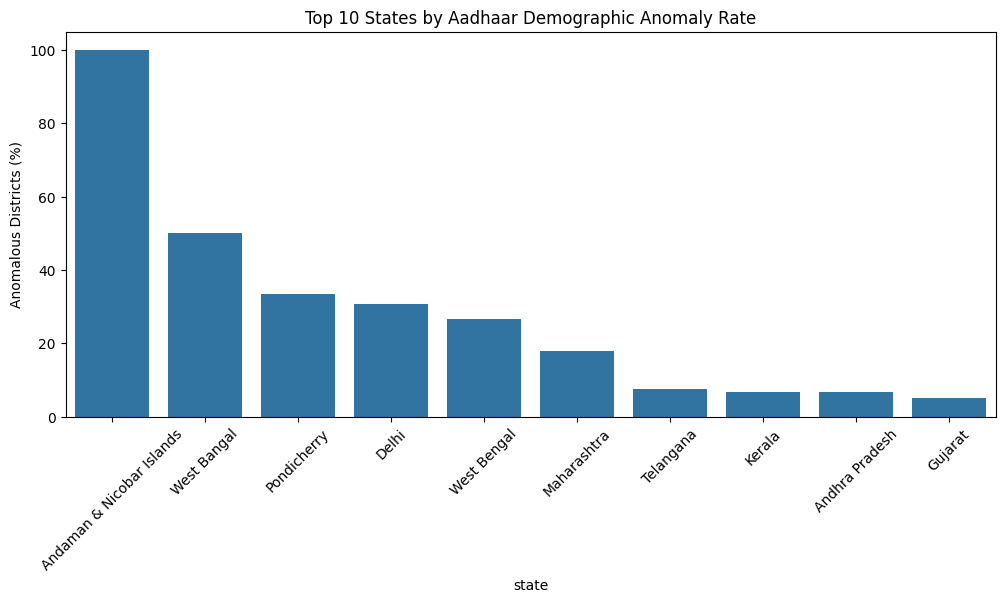

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

top_states = state_df.sort_values(
    "anomaly_percentage",
    ascending=False
).head(10)

plt.figure(figsize=(12,5))
sns.barplot(
    x="state",
    y="anomaly_percentage",
    data=top_states
)
plt.xticks(rotation=45)
plt.ylabel("Anomalous Districts (%)")
plt.title("Top 10 States by Aadhaar Demographic Anomaly Rate")
plt.show()


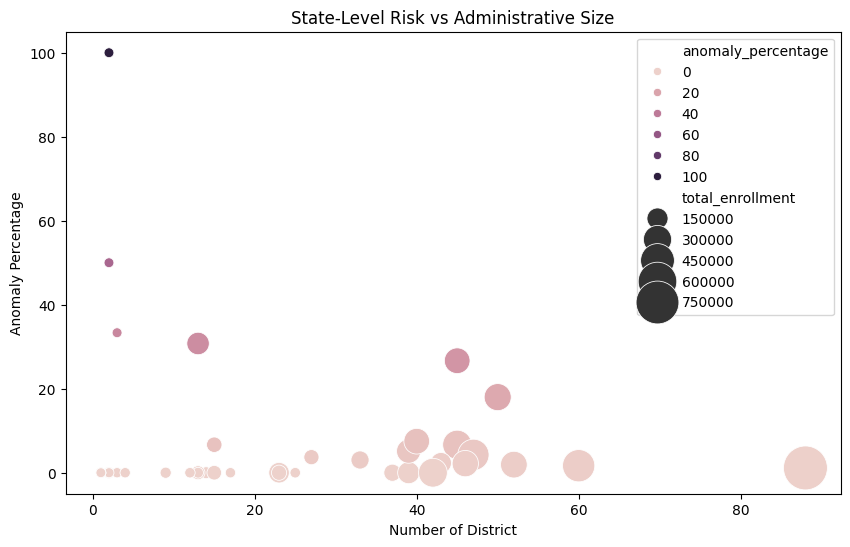

In [110]:
# State Size vs Risk
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="num_districts",
    y="anomaly_percentage",
    size="total_enrollment",
    hue="anomaly_percentage",
    data=state_df,
    sizes=(50, 1000)
)

plt.xlabel("Number of District")
plt.ylabel("Anomaly Percentage")
plt.title("State‑Level Risk vs Administrative Size")
plt.show()

# This helps distinguish between large states with isolated issues and smaller states with systemic anomalies


In [111]:
state_df.to_csv("uidai_state_level_anomalies.csv", index=False)
